In [1]:
import random
from shapely.geometry import Polygon, Point, MultiPoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import requests

In [2]:
#South Park 9 hole course hole 1
p_list = [(40.321854, -79.996663), (40.321823, -79.996694), (40.321793, -79.996705)
            , (40.321757, -79.996703), (40.321726, -79.996688), (40.321703, -79.996669)
            , (40.321679, -79.996646), (40.321665, -79.996612), (40.321651, -79.996570)
            , (40.321644, -79.996539), (40.321649, -79.996498), (40.321662, -79.996465)
            , (40.321683, -79.996442), (40.321712, -79.996427), (40.321739, -79.996421)
            , (40.321769, -79.996425), (40.321790, -79.996437), (40.321807, -79.996449)
            , (40.321829, -79.996468), (40.321843, -79.996489), (40.321858, -79.996516)
            , (40.321870, -79.996548), (40.321874, -79.996583), (40.321870, -79.996625)]
p = Polygon(p_list)

In [ ]:
#Berkley hole 5
p_list = [(40.289288, -78.932620), (40.289309, -78.932644), (40.289337, -78.932660)
            , (40.289366, -78.932667), (40.289399, -78.932655), (40.289421, -78.932637)
            , (40.289440, -78.932596), (40.289450, -78.932553), (40.289449, -78.932511)
            , (40.289441, -78.932459), (40.289433, -78.932427), (40.289412, -78.932389)
            , (40.289391, -78.932366), (40.289361, -78.932357), (40.289337, -78.932359)
            , (40.289319, -78.932362), (40.289299, -78.932380), (40.289281, -78.932409)
            , (40.289268, -78.932426), (40.289261, -78.932452), (40.289254, -78.932486)
            , (40.289253, -78.932521), (40.289256, -78.932547), (40.289264, -78.932580)]
p = Polygon(p_list)

In [3]:
#Assigning points within the perimeter
xmin, ymin, xmax, ymax = p.bounds  # -4.85674599573635, 37.174925051829, -4.85258684662671, 37.1842384372115
n = 3e5
x = np.arange(np.floor(xmin * n) / n, np.ceil(xmax * n) / n, 1 / n)  # array([-4.857, -4.856, -4.855, -4.854, -4.853])
y = np.arange(np.floor(ymin * n) / n, np.ceil(ymax * n) / n, 1 / n)  # array([37.174, 37.175, 37.176, 37.177, 37.178, 37.179, 37.18 , 37.181, 37.182, 37.183, 37.184, 37.185])
points = MultiPoint(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]))
result = points.intersection(p)

In [4]:
#Parsing interior points and adding to list
center_points = []
i = 0
while i < len(result):
    center = [result[i].x,result[i].y]
    center_points.append(center)
    i += 1

In [5]:
#merging perimeter and interior points into dataframe and dropping any duplicates, pretty sure this is useless now
api_list = p_list + center_points
api_df = pd.DataFrame(api_list)
api_df.columns = ['longitude','latitude']
api_df = api_df.drop_duplicates()

In [10]:
#iterates through the list of points in batches of 200 to stay within the API limit
i = 0
j = len(api_list)
out_list = []
while i < j:
    loc_str = ''
    api_list_temp = api_list[i:(i+200)]
    for a in api_list_temp:
        if len(loc_str) == 0:
            loc_str = str(a[0]) + ',' + str(a[1])
        else:
            loc_str = loc_str + '|' + str(a[0]) + ',' + str(a[1])
    key = 'keyhere'
    url = "https://maps.googleapis.com/maps/api/elevation/json?locations={}&key={}".format(loc_str,key)
    payload={}
    headers = {}
    response = requests.request("GET", url, headers=headers, data=payload)
    for attribute, value in response.json().items():
        for v in value:
            if attribute == 'results':
                for key, value in v.items():
                    if key == 'elevation':
                        elevation = value
                    elif key == 'location':
                        lat = v.get('location').get('lat')
                        lng = v.get('location').get('lng')
                temp = [lat,lng,elevation]
                out_list.append(temp)
    i += 200

In [13]:
api_df = pd.DataFrame(out_list)
api_df.columns = ['longitude','latitude','elevation']

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

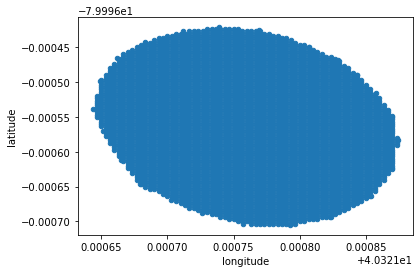

In [14]:
api_df.plot.scatter(x='longitude', y = 'latitude')

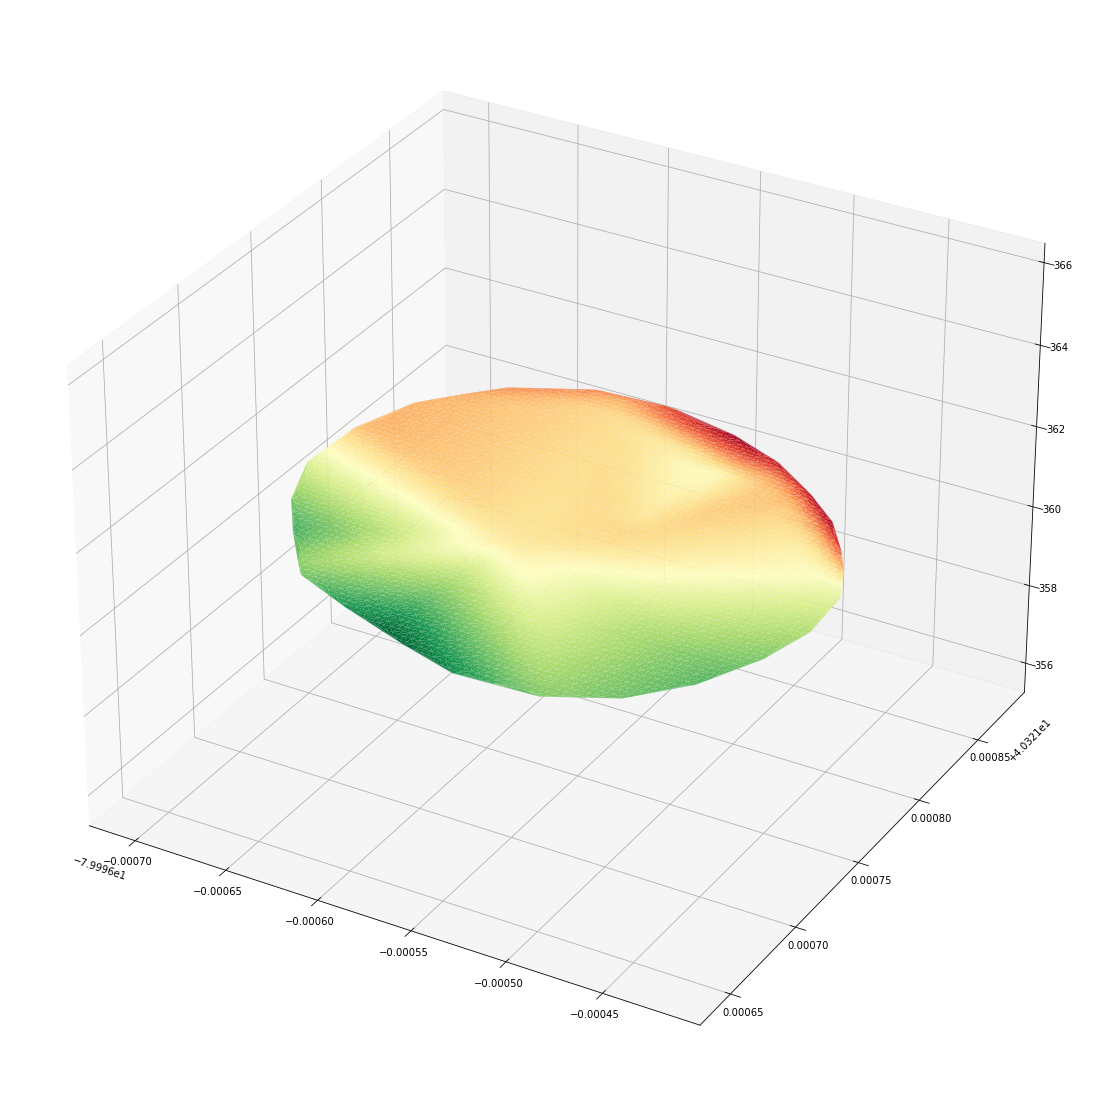

In [15]:
# Get X, Y, Z
X, Y, Z = api_df['latitude'], api_df['longitude'], api_df['elevation']

# Plot X,Y,Z
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(X, Y, Z, cmap = 'RdYlGn')
ax.set_zlim(api_df['elevation'].min()-5, api_df['elevation'].max() + 5)
plt.show()